In [483]:
import os
import speech_recognition as sr
import librosa
import librosa.display
import pandas as pd
from scipy import signal
import IPython.display as ipd
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model


from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Input, Flatten, Dropout, Activation, Dense
import keras
from keras import regularizers

import librosa
import librosa.display
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2


## Read Audio Files

In [387]:
os.listdir(path='Audio_Speech_Actors')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        elsezz:
            allFiles.append(fullPath)
    return allFiles

dirName = 'Audio_Speech_Actors'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

1441

In [388]:
listOfFiles[0]

'Audio_Speech_Actors/Actor_16/03-01-05-01-02-01-16.wav'

## Delete DS File

In [389]:
listOfFiles.index('Audio_Speech_Actors/.DS_Store')

480

In [390]:
listOfFiles.pop(480)

'Audio_Speech_Actors/.DS_Store'

In [393]:
def read_audio(list_audio):
    data_list=[]
    sampling_rate_list=[]
    normal_duration=[]
    for audio in list_audio:
        data, sampling_rate = librosa.load(audio)
        data_list.append(data)
        sampling_rate_list.append(sampling_rate)
        normal_duration.append(librosa.core.get_duration(data,sample_rate))
    return data_list, sampling_rate_list,normal_duration
data_list, sampling_rate_list, duration=read_audio(listOfFiles)

## Create DataFrame 



Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [394]:
data = pd.DataFrame(columns=['Path', 'Emotion', 'Emotion_intensity','Statement','Gender', 'Duration']) 

In [395]:
speech_dir = 'Audio_Speech_Actors/'
actors = [dir for dir in os.listdir(speech_dir) if dir.startswith('Actor_')]
print(actors)

['Actor_16', 'Actor_11', 'Actor_18', 'Actor_20', 'Actor_21', 'Actor_19', 'Actor_10', 'Actor_17', 'Actor_04', 'Actor_03', 'Actor_02', 'Actor_05', 'Actor_12', 'Actor_15', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_14', 'Actor_13', 'Actor_09', 'Actor_07', 'Actor_06', 'Actor_01', 'Actor_08']


In [396]:
# Iterated through every data folders and the data 
for dir in actors:
    act_dir = os.path.join(speech_dir,dir)
    for wav in os.listdir(act_dir):
        # get file name with labels
        identifiers = wav.split('.')[0].split('-')
        # Extracted file name and stored it in list after spliting
        emotion = (int(identifiers[2]))
        # lable corrsponding to emotion is stored in variable emotion
        emotion_intensity = (int(identifiers[3]))
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        # extracted gender lable based on label value (even for female and odd for male)
        statement = (int(identifiers[4]))
        # extract statement 
        file_path = os.path.join(act_dir, wav).replace("\\","/")
        # chage the path representation in windows
        data = data.append({"Path": file_path,
                            "Emotion": emotion,
                            "Emotion_intensity": emotion_intensity,
                            "Statement": statement,
                            "Gender": gender,
                             },
                             ignore_index = True
                          )
data['Duration']= duration
        # Append the extrated labels to data frame.

In [397]:
def label_emotion(emotion):
    """
    This method is called to label the emotion into one of 8 categories.
    """
    if emotion == 1 :
        return 'neutral'
    elif emotion == 2:
        return 'calm'
    elif emotion == 3:
        return 'happy'
    elif emotion == 4:
        return 'sad'
    elif emotion == 5:
        return 'angry'
    elif emotion == 6:
        return 'fearful'
    elif emotion == 7:
        return 'disgust'
    else: 
        return 'surprised'

In [398]:
data['Emotion']= data.Emotion.apply(label_emotion)

In [399]:
def label_statement(statement):
    """
    This method is called to label the statement into one of 2 categories.
    """
    if statement == 1 :
        return 'kids'
    else: 
        return 'dogs'

In [400]:
data['Statement']= data.Statement.apply(label_statement)

In [401]:
def label_intensity(intensity):
    """
    This method is called to label the intensity into one of 2 categories.
    """
    if intensity == 1 :
        return 'normal'
    else: 
        return 'strong'

In [402]:
data['Emotion_intensity']= data.Emotion_intensity.apply(label_intensity)

In [403]:
data

,Path,Emotion,Emotion_intensity,Statement,Gender,Duration
0,Audio_Speech_Actors/Actor_16/03-01-05-01-02-01...,angry,normal,dogs,female,1.951950
1,Audio_Speech_Actors/Actor_16/03-01-06-01-02-02...,fearful,normal,dogs,female,1.785125
2,Audio_Speech_Actors/Actor_16/03-01-06-02-01-02...,fearful,strong,kids,female,1.868549
3,Audio_Speech_Actors/Actor_16/03-01-05-02-01-01...,angry,strong,kids,female,1.985329
4,Audio_Speech_Actors/Actor_16/03-01-07-01-01-01...,disgust,normal,kids,female,1.885238
...,...,...,...,...,...,...
1435,Audio_Speech_Actors/Actor_08/03-01-03-02-02-02...,happy,strong,dogs,female,1.968639
1436,Audio_Speech_Actors/Actor_08/03-01-03-01-01-02...,happy,normal,kids,female,1.718390
1437,Audio_Speech_Actors/Actor_08/03-01-02-02-01-01...,calm,strong,kids,female,1.818481
1438,Audio_Speech_Actors/Actor_08/03-01-02-01-02-01...,calm,normal,dogs,female,1.735079


In [404]:
def target(gender, emotion):
    """
    This method is called to label the statement into one of 2 categories.
    """
    return gender+'_'+emotion 

In [405]:
data['Target']= data.apply(lambda x: target(x.Gender, x.Emotion), axis=1)

In [406]:
data['audio_data']= data_list

In [442]:
data

,Path,Emotion,Emotion_intensity,Statement,Gender,Duration,Target,audio_data
0,Audio_Speech_Actors/Actor_16/03-01-05-01-02-01...,angry,normal,dogs,female,1.951950,female_angry,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Audio_Speech_Actors/Actor_16/03-01-06-01-02-02...,fearful,normal,dogs,female,1.785125,female_fearful,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Audio_Speech_Actors/Actor_16/03-01-06-02-01-02...,fearful,strong,kids,female,1.868549,female_fearful,"[3.0036153e-05, 2.7443759e-05, 9.890327e-07, 6..."
3,Audio_Speech_Actors/Actor_16/03-01-05-02-01-01...,angry,strong,kids,female,1.985329,female_angry,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Audio_Speech_Actors/Actor_16/03-01-07-01-01-01...,disgust,normal,kids,female,1.885238,female_disgust,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1435,Audio_Speech_Actors/Actor_08/03-01-03-02-02-02...,happy,strong,dogs,female,1.968639,female_happy,"[-3.5647103e-05, -5.6249388e-05, -3.715587e-05..."
1436,Audio_Speech_Actors/Actor_08/03-01-03-01-01-02...,happy,normal,kids,female,1.718390,female_happy,"[-1.3109808e-06, -5.2740556e-06, -2.2491471e-0..."
1437,Audio_Speech_Actors/Actor_08/03-01-02-02-01-01...,calm,strong,kids,female,1.818481,female_calm,"[-2.8233026e-07, 2.3358811e-07, -1.6015822e-07..."
1438,Audio_Speech_Actors/Actor_08/03-01-02-01-02-01...,calm,normal,dogs,female,1.735079,female_calm,"[-0.00014092414, -0.00021190503, -0.0001948409..."


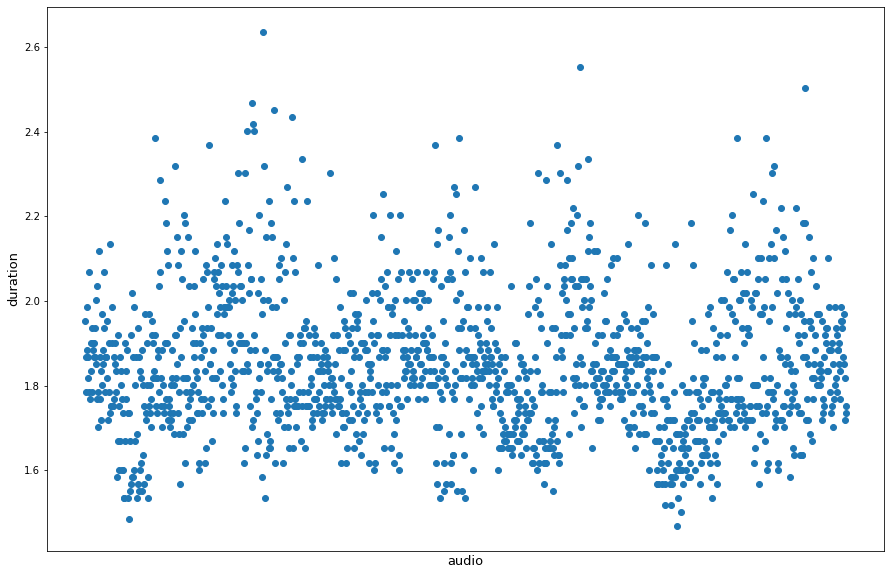

In [410]:
plt.rcParams["figure.figsize"] = (15,10)
audio_path = data['Path']
duration = data['Duration']
plt.xlabel("audio",fontsize=13);
plt.ylabel("duration",fontsize=13);
plt.xticks([])
plt.scatter(audio_path,duration)
plt.show()

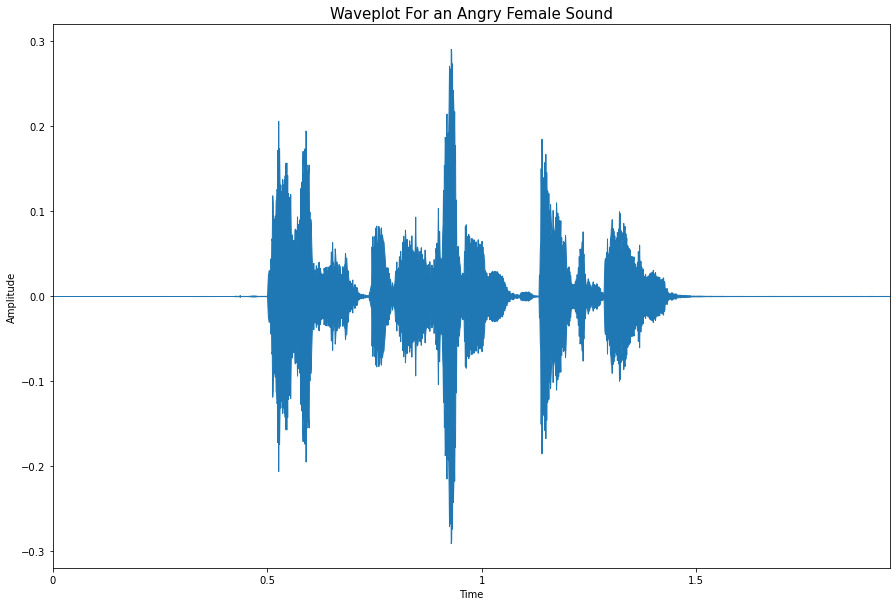

In [443]:
librosa.display.waveplot(data['audio_data'][0],sr=sample_rate);
plt.ylabel("Amplitude")
plt.title('Waveplot For an Angry Female Sound', fontsize=15);

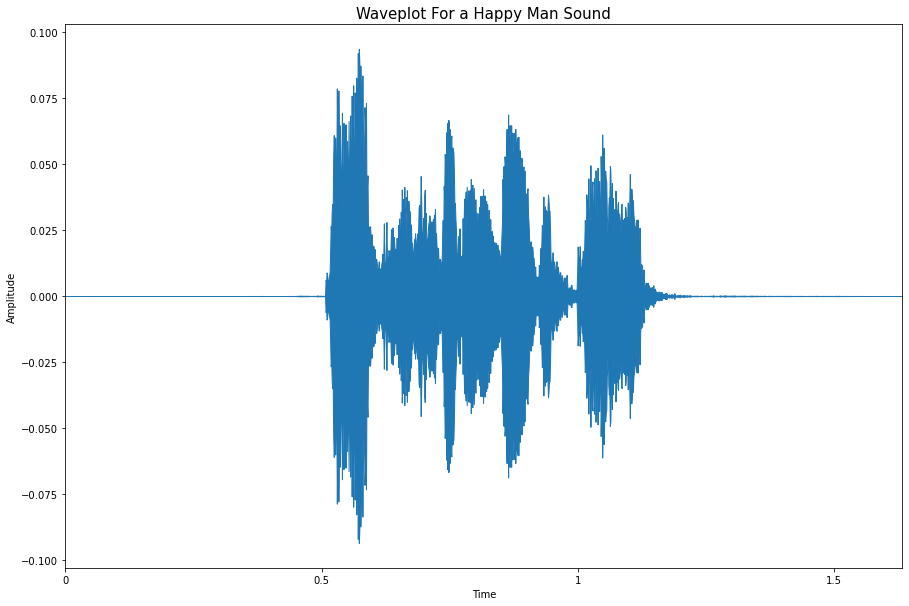

In [441]:
librosa.display.waveplot(data['audio_data'][853],sr=sample_rate);
plt.ylabel("Amplitude")
plt.title('Waveplot For a Happy Man Sound', fontsize=15);

## Spectrograms 

In [584]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile


for path in listOfFiles:
    sample_rate, samples = wavfile.read(path)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    
spec_path= 'spectograms/'
for path in listOfFiles:
        fname = path.split('/')[-1].split('.')[0]
        samples, sample_rate = librosa.load(path,sr=None)
        
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_axis_off()
        ax.specgram(samples,Fs=2);
        fig.savefig(spec_path+fname_d+'.png')
        plt.close(fig)
        del sample_rate, samples, fig, ax  

<ipython-input-584-95322a0ab44c>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, samples = wavfile.read(path)


In [411]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [412]:
filename = data.Path[0]

Text(0.5, 0, 'Seconds')

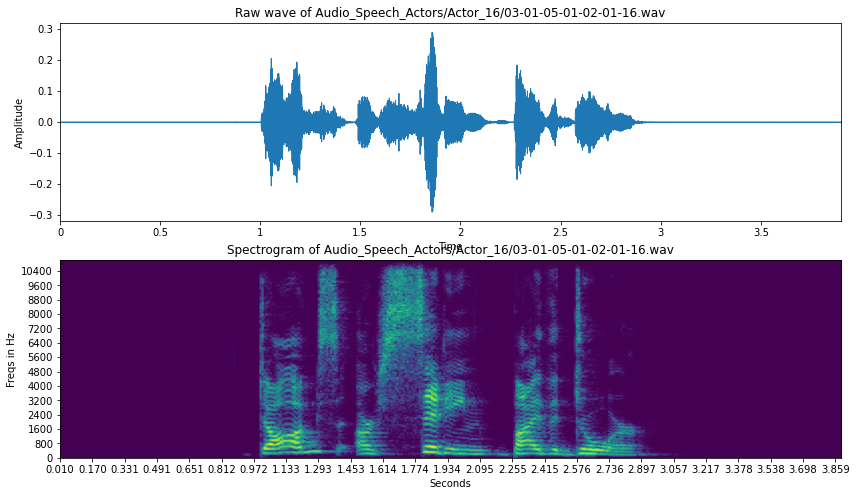

In [413]:
spec_path= 'spectograms/'
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(data_list[0], sampling_rate_list[0])

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(data_list[0], sr=sampling_rate_list[0])

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [414]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [415]:
# Trim the silence voice
aa , bb = librosa.effects.trim(data_list[0], top_db=30)
aa, bb

(array([-1.8758229e-04, -1.1675138e-04, -1.1105111e-04, ...,
        -5.7289176e-06,  1.3341569e-05, -1.0213388e-04], dtype=float32),
 array([21504, 64000]))

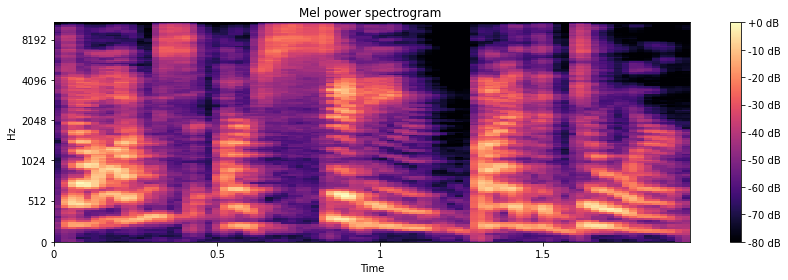

In [416]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sampling_rate_list[0], n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sampling_rate_list[0], x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

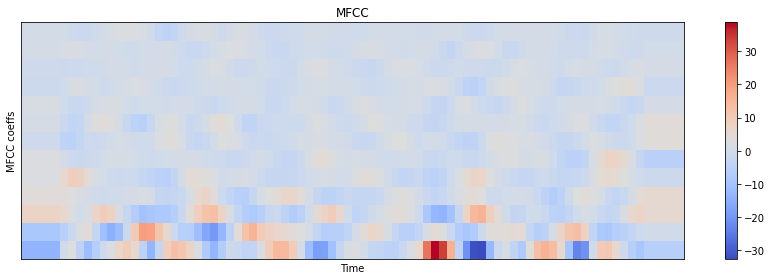

In [417]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [418]:
S.shape

(128, 84)

In [419]:
mfcc.shape

(13, 84)

## Features Extraction 

In [420]:
from tqdm import tqdm
input_duration=3

audio = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data))):
    X, sample_rate = librosa.load(data.Path[i],
                                  res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    audio.loc[i] = [feature]

100%|██████████| 1440/1440 [01:51<00:00, 12.94it/s]


In [421]:
audio

,feature
0,"[-55.07453, -55.07453, -55.07453, -55.07453, -..."
1,"[-54.388466, -54.388466, -54.388466, -54.38846..."
2,"[-42.791096, -42.925762, -42.899185, -42.68892..."
3,"[-45.452774, -45.452774, -45.452774, -45.45277..."
4,"[-62.8723, -62.8723, -62.8723, -62.8723, -62.8..."
...,...
1435,"[-52.7948, -53.763607, -55.00385, -54.96499, -..."
1436,"[-53.335293, -54.241184, -52.663242, -53.00668..."
1437,"[-55.19314, -55.72388, -56.97952, -60.7733, -5..."
1438,"[-62.298923, -58.117092, -52.51449, -49.66577,..."


In [422]:
featurs_data = pd.DataFrame(audio['feature'].values.tolist())
Target = data.Target

In [423]:
featurs_data = pd.concat([featurs_data,Target], axis=1)

In [424]:
featurs_data

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,Target
0,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,...,-55.074532,-54.697842,-53.741127,-54.621086,-54.546001,-54.562290,-55.074532,-54.986717,-55.074532,female_angry
1,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,...,-53.333660,-54.219997,-54.251675,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,female_fearful
2,-42.791096,-42.925762,-42.899185,-42.688927,-42.425762,-42.087055,-41.129875,-40.550945,-39.232639,-39.827827,...,-42.256557,-42.267982,-42.284805,-42.284805,-42.284805,-42.284805,-42.284805,-42.080303,-42.278969,female_fearful
3,-45.452774,-45.452774,-45.452774,-45.452774,-45.452774,-45.452774,-45.452774,-45.452774,-45.452774,-45.452774,...,-45.452774,-45.452774,-44.339504,-45.410488,-45.452774,-45.443420,-44.609249,-44.860779,-45.452774,female_angry
4,-62.872299,-62.872299,-62.872299,-62.872299,-62.872299,-62.872299,-62.872299,-62.872299,-62.872299,-62.872299,...,-60.132027,-59.421566,-56.944618,-55.152115,-56.732174,-62.172836,-61.767502,-58.865089,-56.552303,female_disgust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-52.794800,-53.763607,-55.003849,-54.964989,-54.323025,-55.138943,-51.768867,-51.738060,-51.537483,-50.650475,...,-48.470703,-47.581318,-45.567196,-45.458992,-42.654377,-41.474724,-40.475830,-38.452927,-36.337105,female_happy
1436,-53.335293,-54.241184,-52.663242,-53.006680,-52.754692,-52.673523,-51.280819,-52.471199,-52.866074,-51.250862,...,-54.236790,-55.375771,-52.620754,NaN,NaN,NaN,NaN,NaN,NaN,female_happy
1437,-55.193138,-55.723881,-56.979519,-60.773300,-55.671585,-53.729599,-53.668484,-53.156345,-54.001930,-55.969090,...,-62.107414,-59.763035,-57.989464,-56.036190,-56.420681,-59.163715,-57.135174,-59.056145,-58.450710,female_calm
1438,-62.298923,-58.117092,-52.514488,-49.665771,-50.454319,-52.708809,-52.650169,-51.722149,-51.405098,-55.263344,...,-53.134724,-51.981689,-52.611149,-54.987103,-55.162971,-54.362507,NaN,NaN,NaN,female_calm


In [425]:
featurs_data.isna().sum()

0           0
1           0
2           0
3           0
4           0
         ... 
255       316
256       377
257       377
258       377
Target      0
Length: 260, dtype: int64

In [426]:
featurs_data.fillna(0, inplace=True)

In [427]:
featurs_data.isna().sum()

0         0
1         0
2         0
3         0
4         0
         ..
255       0
256       0
257       0
258       0
Target    0
Length: 260, dtype: int64

## Augmentation on raw data

In [428]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

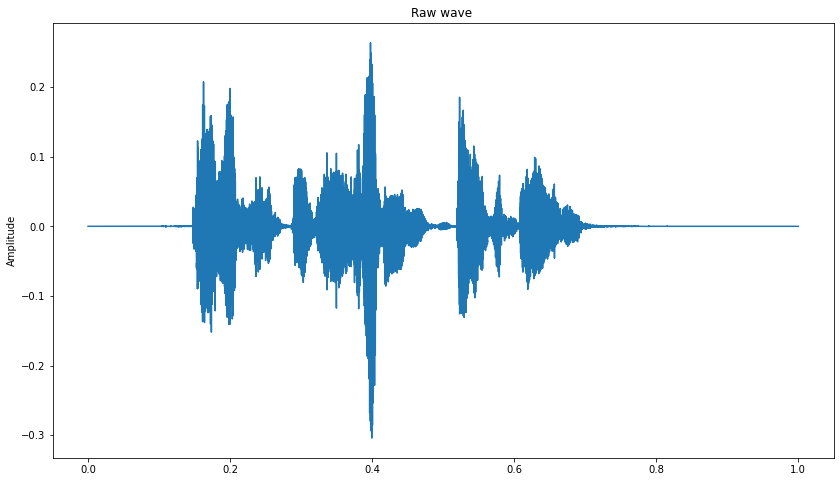

In [429]:
X, sample_rate = librosa.load(data.Path[0], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

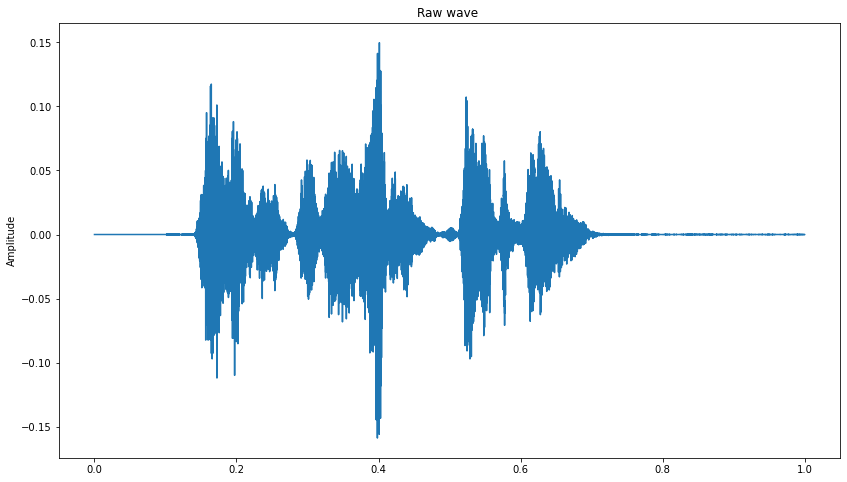

In [430]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

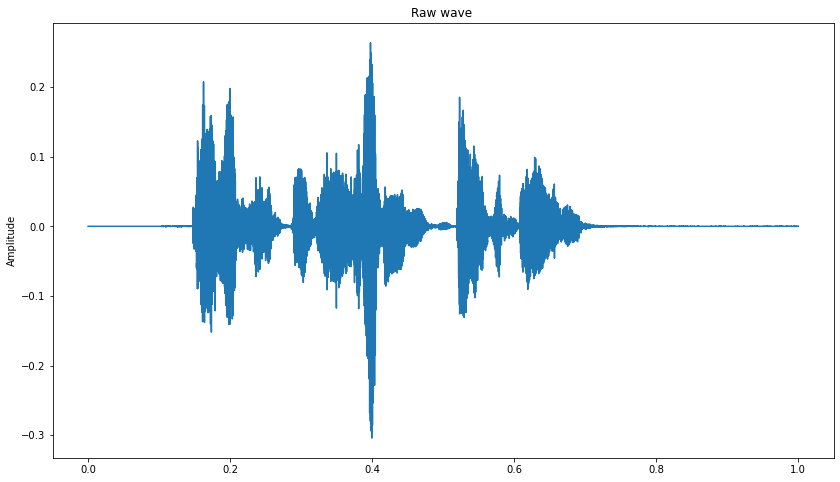

In [431]:
x = noise(X)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

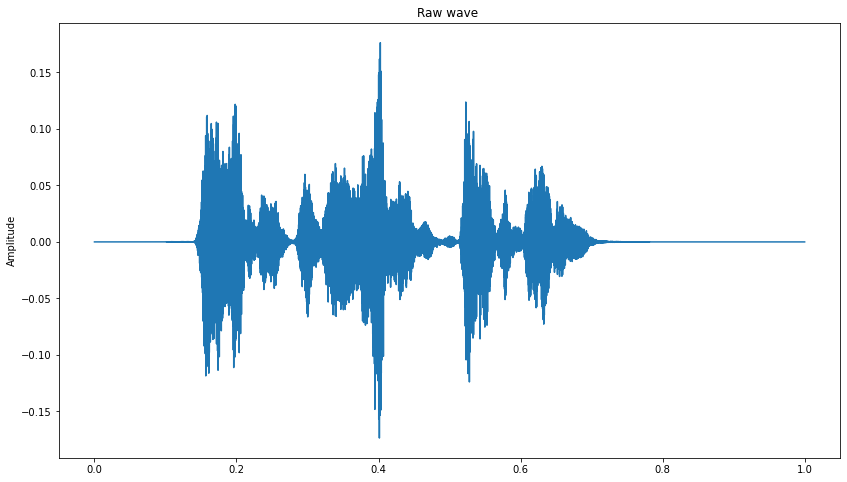

In [432]:
x = stretch(X,rate=0.6)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [452]:
# Augmentation Method 1
syn_data1 = pd.DataFrame(columns=['Feature', 'Target'])
for i in tqdm(range(len(data))):
    X, sample_rate = librosa.load(data.Path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data.Target[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data.Timport matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile


for path in listOfFiles:
    sample_rate, samples = wavfile.read(path)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    
spec_path= 'spectograms/'
for path in listOfFiles:
        fname = path.split('/')[-1].split('.')[0]
        samples, sample_rate = librosa.load(path,sr=None)
        
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_axis_off()
        ax.specgram(samples,Fs=2);
        fname_d=fname+'.png'
        fig.savefig(spec_path+fname_d,bbox_inches="tight",pad_inches=0)
        plt.close(fig)
        del sample_rate, samples, fig, ax  arget[i]]

100%|██████████| 1440/1440 [01:50<00:00, 13.04it/s]


In [453]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['Feature', 'Target'])
for i in tqdm(range(len(data))):
    X, sample_rate = librosa.load(data.Path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data.Target[i]:
        X = stretch(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data.Target[i]]

100%|██████████| 1440/1440 [03:35<00:00,  6.69it/s]


In [454]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [455]:
df4 = pd.DataFrame(syn_data1['Feature'].values.tolist())
labels4 = syn_data1.Target
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "Target"})
syndf1 = syndf1.fillna(0)

In [456]:
df5 = pd.DataFrame(syn_data2['Feature'].values.tolist())
labels5 = syn_data2.Target
syndf2 = pd.concat([df5,labels5], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "Target"})
syndf2 = syndf2.fillna(0)

In [457]:
len(syn_data2)

1440

In [458]:
# Combining the Augmented data with original
combined_df = pd.concat([featurs_data, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,313,314,315,316,317,318,319,320,321,322
0,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,-54.388466,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-42.791096,-42.925762,-42.899185,-42.688927,-42.425762,-42.087055,-41.129875,-40.550945,-39.232639,-39.827827,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-45.452774,-45.452774,-45.452774,-45.452774,-45.452774,-45.452774,-45.452774,-45.452774,-45.452774,-45.452774,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-62.872299,-62.872299,-62.872299,-62.872299,-62.872299,-62.872299,-62.872299,-62.872299,-62.872299,-62.872299,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,-54.228569,-55.209988,-57.006229,-57.516212,-56.979614,-57.135418,-56.813946,-57.595314,-56.697197,-55.108322,...,-52.090244,-49.241489,-48.862358,-48.153713,-47.725410,-45.606567,-43.591228,-43.015465,-42.781902,-43.626396
4316,-53.673393,-55.565529,-56.133766,-54.481808,-54.689152,-54.687336,-54.231499,-53.881004,-54.518085,-55.776646,...,-58.085037,-58.283699,-58.153038,-60.296806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4317,-55.199184,-56.364605,-57.780319,-58.562607,-61.047947,-59.350754,-55.148006,-55.180195,-55.794003,-55.319160,...,-62.034058,-62.736286,-60.477234,-59.156269,-58.868103,-58.594482,-58.787205,-59.341988,-61.007915,-61.117569
4318,-61.585678,-59.360615,-57.027908,-54.754948,-51.723282,-51.954834,-54.422421,-56.907856,-56.377335,-55.454609,...,-57.948242,-56.319656,-57.236759,-57.544758,-55.760803,-56.794819,-59.717728,0.000000,0.000000,0.000000


In [459]:
combined_df.Target

0         female_angry
1       female_fearful
2       female_fearful
3         female_angry
4       female_disgust
             ...      
4315      female_happy
4316      female_happy
4317       female_calm
4318       female_calm
4319    female_neutral
Name: Target, Length: 4320, dtype: object

## Split Data

In [504]:
X= combined_df.drop('Target', axis=1)
y= combined_df.Target

In [505]:
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [506]:
X_train , X_test, y_train,y_test = train_test_split(X,y, test_size=.2, random_state= 42)
X_train , X_val, y_train,y_val = train_test_split(X_train,y_train, test_size=.25, random_state= 42)

In [502]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [503]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [507]:
print(lb.classes_)

['female_angry' 'female_calm' 'female_disgust' 'female_fearful'
 'female_happy' 'female_neutral' 'female_sad' 'female_surprised'
 'male_angry' 'male_calm' 'male_disgust' 'male_fearful' 'male_happy'
 'male_neutral' 'male_sad' 'male_surprised']


In [477]:
y_train_hot = tf.one_hot(y_train, 16)

In [466]:
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [475]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.019675925925925927

In [476]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.2962962962962963

In [479]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=70)
knn.fit(X_train, y_train)
knn.predict(X_test)
knn.score(X_test, y_test)

0.010416666666666666

## Model 

### First Model

In [537]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

## FeedForward NN

###  Baseline Traditional NN

In [731]:
ff_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(units=500,activation='relu'),
    keras.layers.Dense(units=300,activation='relu'),
    keras.layers.Dense(units=200,activation='relu'),
    keras.layers.Dense(units=16,activation='softmax')
])
ff_model.compile('sgd',loss='mean_absolute_error',metrics=['categorical_accuracy'])
ff_model.summary()

Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_190 (Dense)           (None, 500)               162000    
                                                                 
 dense_191 (Dense)           (None, 300)               150300    
                                                                 
 dense_192 (Dense)           (None, 200)               60200     
                                                                 
 dense_193 (Dense)           (None, 16)                3216      
                                                                 
Total params: 375,716
Trainable params: 375,716
Non-trainable params: 0
_________________________________________________________________


In [732]:
model_history=ff_model.fit(X_train, y_train,batch_size=32, epochs=10, verbose=1)

Epoch 1/10
81/81 [==============================] - 1s 4ms/step - loss: 0.1166 - categorical_accuracy: 0.0671
Epoch 2/10
81/81 [==============================] - 0s 5ms/step - loss: 0.1165 - categorical_accuracy: 0.0679
Epoch 3/10
81/81 [==============================] - 0s 5ms/step - loss: 0.1162 - categorical_accuracy: 0.0706
Epoch 4/10
81/81 [==============================] - 0s 4ms/step - loss: 0.1161 - categorical_accuracy: 0.0710
Epoch 5/10
81/81 [==============================] - 0s 4ms/step - loss: 0.1161 - categorical_accuracy: 0.0714
Epoch 6/10
81/81 [==============================] - 0s 5ms/step - loss: 0.1165 - categorical_accuracy: 0.0691
Epoch 7/10
81/81 [==============================] - 0s 4ms/step - loss: 0.1158 - categorical_accuracy: 0.0741
Epoch 8/10
81/81 [==============================] - 0s 4ms/step - loss: 0.1151 - categorical_accuracy: 0.0791
Epoch 9/10
81/81 [==============================] - 0s 4ms/step - loss: 0.1126 - categorical_accuracy: 0.0999
Epoch 10/1

## Baseline with more layers 

In [733]:
ff_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(units=800,activation='relu'),
    keras.layers.Dense(units=600,activation='relu'),
    keras.layers.Dense(units=500,activation='relu'),
    keras.layers.Dense(units=400,activation='relu'),
    keras.layers.Dense(units=200,activation='relu'),
    keras.layers.Dense(units=128,activation='relu'),
    keras.layers.Dense(units=90,activation='relu'),
    keras.layers.Dense(units=46,activation='relu'),
    keras.layers.Dense(units=16,activation='softmax')
])
ff_model.compile('sgd',loss='mean_absolute_error',metrics=['categorical_accuracy'])
ff_model.summary()

Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_194 (Dense)           (None, 800)               259200    
                                                                 
 dense_195 (Dense)           (None, 600)               480600    
                                                                 
 dense_196 (Dense)           (None, 500)               300500    
                                                                 
 dense_197 (Dense)           (None, 400)               200400    
                                                                 
 dense_198 (Dense)           (None, 200)               80200     
                                                                 
 dense_199 (Dense)           (None, 128)               25728     
                                                                 
 dense_200 (Dense)           (None, 90)             

In [734]:
model_history=ff_model.fit(X_train, y_train,batch_size=32, epochs=100, verbose=1)

Epoch 1/100
81/81 [==============================] - 2s 15ms/step - loss: 0.1158 - categorical_accuracy: 0.0733
Epoch 2/100
81/81 [==============================] - 1s 12ms/step - loss: 0.1133 - categorical_accuracy: 0.1046
Epoch 3/100
81/81 [==============================] - 1s 12ms/step - loss: 0.1111 - categorical_accuracy: 0.1223
Epoch 4/100
81/81 [==============================] - 1s 12ms/step - loss: 0.1099 - categorical_accuracy: 0.1316
Epoch 5/100
81/81 [==============================] - 1s 11ms/step - loss: 0.1090 - categorical_accuracy: 0.1377
Epoch 6/100
81/81 [==============================] - 1s 11ms/step - loss: 0.1084 - categorical_accuracy: 0.1408
Epoch 7/100
81/81 [==============================] - 1s 11ms/step - loss: 0.1084 - categorical_accuracy: 0.1385
Epoch 8/100
81/81 [==============================] - 1s 11ms/step - loss: 0.1080 - categorical_accuracy: 0.1439
Epoch 9/100
81/81 [==============================] - 1s 11ms/step - loss: 0.1076 - categorical_accuracy:

81/81 [==============================] - 1s 13ms/step - loss: 0.1019 - categorical_accuracy: 0.1887
Epoch 74/100
81/81 [==============================] - 1s 10ms/step - loss: 0.1020 - categorical_accuracy: 0.1933
Epoch 75/100
81/81 [==============================] - 1s 10ms/step - loss: 0.1016 - categorical_accuracy: 0.1968
Epoch 76/100
81/81 [==============================] - 1s 11ms/step - loss: 0.1017 - categorical_accuracy: 0.1956
Epoch 77/100
81/81 [==============================] - 1s 10ms/step - loss: 0.1017 - categorical_accuracy: 0.1929
Epoch 78/100
81/81 [==============================] - 1s 9ms/step - loss: 0.1017 - categorical_accuracy: 0.1933
Epoch 79/100
81/81 [==============================] - 1s 10ms/step - loss: 0.1014 - categorical_accuracy: 0.1960
Epoch 80/100
81/81 [==============================] - 1s 11ms/step - loss: 0.1014 - categorical_accuracy: 0.1968
Epoch 81/100
81/81 [==============================] - 1s 11ms/step - loss: 0.1016 - categorical_accuracy: 0.19

### 1D

In [735]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(Activation('relu'))
model.add(layers.Flatten())
model.add(Dense(16))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_282 (Conv1D)         (None, 323, 256)          2304      
                                                                 
 activation_311 (Activation)  (None, 323, 256)         0         
                                                                 
 conv1d_283 (Conv1D)         (None, 323, 256)          524544    
                                                                 
 activation_312 (Activation)  (None, 323, 256)         0         
                                                                 
 flatten_54 (Flatten)        (None, 82688)             0         
                                                                 
 dense_203 (Dense)           (None, 16)                1323024   
                                                                 
 activation_313 (Activation)  (None, 16)            

/Users/amjad/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [736]:
model_history=model.fit(X_train, y_train,batch_size=32, epochs=10, verbose=1)

Epoch 1/10
81/81 [==============================] - 32s 392ms/step - loss: 3.5319 - categorical_accuracy: 0.0845
Epoch 2/10
81/81 [==============================] - 34s 420ms/step - loss: 2.7585 - categorical_accuracy: 0.1169
Epoch 3/10
81/81 [==============================] - 38s 470ms/step - loss: 2.5986 - categorical_accuracy: 0.1327
Epoch 4/10
81/81 [==============================] - 35s 436ms/step - loss: 2.5506 - categorical_accuracy: 0.1435
Epoch 5/10
81/81 [==============================] - 55s 685ms/step - loss: 2.4927 - categorical_accuracy: 0.1663
Epoch 6/10
81/81 [==============================] - 46s 557ms/step - loss: 2.4473 - categorical_accuracy: 0.1775
Epoch 7/10
81/81 [==============================] - 34s 422ms/step - loss: 2.4186 - categorical_accuracy: 0.1875
Epoch 8/10
81/81 [==============================] - 36s 443ms/step - loss: 2.3903 - categorical_accuracy: 0.1894
Epoch 9/10
81/81 [==============================] - 35s 433ms/step - loss: 2.3793 - categorical_

### 1D Complex

In [737]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(16))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

/Users/amjad/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [738]:
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['categorical_accuracy'])

In [739]:
model_history=model.fit(X_train, y_train,batch_size=32, epochs=10, verbose=1)

Epoch 1/10
81/81 [==============================] - 57s 694ms/step - loss: 2.9105 - categorical_accuracy: 0.0613
Epoch 2/10
81/81 [==============================] - 53s 649ms/step - loss: 2.7547 - categorical_accuracy: 0.0818
Epoch 3/10
81/81 [==============================] - 47s 572ms/step - loss: 2.7067 - categorical_accuracy: 0.1019
Epoch 4/10
81/81 [==============================] - 47s 578ms/step - loss: 2.6621 - categorical_accuracy: 0.1192
Epoch 5/10
81/81 [==============================] - 49s 598ms/step - loss: 2.6270 - categorical_accuracy: 0.1505
Epoch 6/10
81/81 [==============================] - 46s 571ms/step - loss: 2.6016 - categorical_accuracy: 0.1505
Epoch 7/10
81/81 [==============================] - 45s 552ms/step - loss: 2.5831 - categorical_accuracy: 0.1721
Epoch 8/10
81/81 [==============================] - 46s 562ms/step - loss: 2.5527 - categorical_accuracy: 0.1744
Epoch 9/10
81/81 [==============================] - 50s 619ms/step - loss: 2.5347 - categorical_

## Another Model

### LSTM

In [746]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=9, strides=1, padding='same', input_shape=(X_train.shape[1],1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Conv1D(filters=64, kernel_size=7, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.LSTM(32, return_sequences=True),
    
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(units=16, activation='softmax')
        ])

model.summary()

Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_298 (Conv1D)         (None, 323, 32)           320       
                                                                 
 batch_normalization_42 (Bat  (None, 323, 32)          128       
 chNormalization)                                                
                                                                 
 activation_329 (Activation)  (None, 323, 32)          0         
                                                                 
 max_pooling1d_101 (MaxPooli  (None, 161, 32)          0         
 ng1D)                                                           
                                                                 
 dropout_126 (Dropout)       (None, 161, 32)           0         
                                                                 
 conv1d_299 (Conv1D)         (None, 161, 64)        

In [747]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-3, momentum=0.8)
# opt = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - 9s 155ms/step - loss: 2.6026 - categorical_accuracy: 0.1335 - val_loss: 3.2198 - val_categorical_accuracy: 0.0741
Epoch 2/10
41/41 [==============================] - 5s 122ms/step - loss: 2.3455 - categorical_accuracy: 0.2006 - val_loss: 3.3366 - val_categorical_accuracy: 0.0880
Epoch 3/10
41/41 [==============================] - 5s 132ms/step - loss: 2.2095 - categorical_accuracy: 0.2230 - val_loss: 3.0742 - val_categorical_accuracy: 0.1238
Epoch 4/10
41/41 [==============================] - 6s 142ms/step - loss: 2.1502 - categorical_accuracy: 0.2442 - val_loss: 2.5533 - val_categorical_accuracy: 0.1944
Epoch 5/10
41/41 [==============================] - 6s 134ms/step - loss: 2.0909 - categorical_accuracy: 0.2608 - val_loss: 2.2880 - val_categorical_accuracy: 0.2188
Epoch 6/10
41/41 [==============================] - 5s 131ms/step - loss: 2.0569 - categorical_accuracy: 0.2751 - val_loss: 2.2852 - val_categorical_accuracy: 0.2292
Epoc

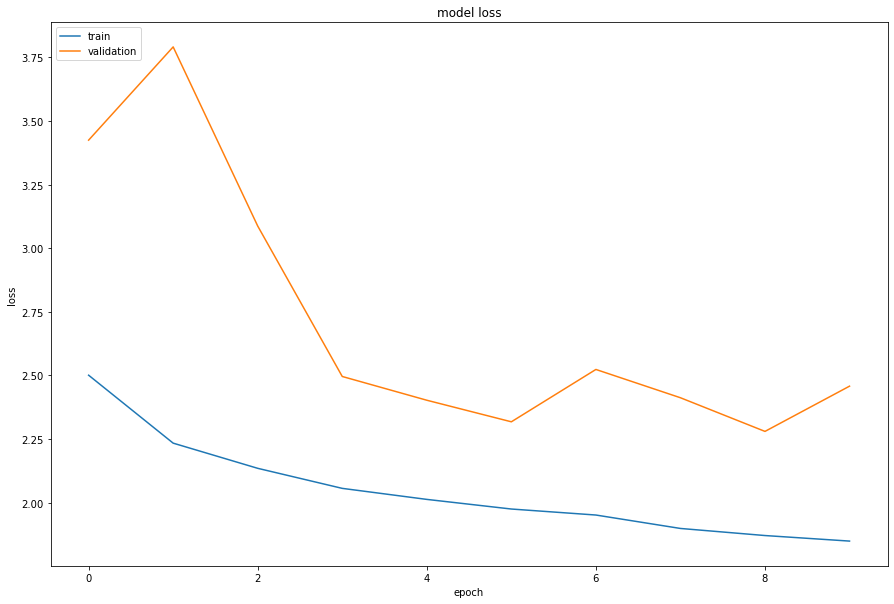

In [726]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [727]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

KeyError: 'categorical_accuracy'

In [701]:
loss, acc = model.evaluate(X_test, y_test)
print("Model Accuracy: {:5.2f}%".format(100*acc))

In [666]:
# New model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
model2D = Sequential()
model2D.add(InputLayer(input_shape=X_train.shape[1:]))
model2D.add(Conv2D(256, 8, padding='same'))
model2D.add(BatchNormalization())
model2D.add(Activation('relu'))
model2D.add(Dropout(0.25))
model2D.add(MaxPooling2D(pool_size=(8)))
model2D.add(Conv2D(128, 8, padding='same'))
model2D.add(Activation('relu'))
model2D.add(Conv2D(128, 8, padding='same'))
model2D.add(Activation('relu'))
model2D.add(Conv2D(128, 8, padding='same'))
model2D.add(Activation('relu'))
model2D.add(Conv2D(128, 8, padding='same'))
model2D.add(BatchNormalization())
model2D.add(Activation('relu'))
model2D.add(Dropout(0.25))
model2D.add(MaxPooling2D(pool_size=(8)))
model2D.add(Conv2D(64, 8, padding='same'))
model2D.add(Activation('relu'))
model2D.add(Conv2D(64, 8, padding='same'))
model2D.add(Activation('relu'))
model2D.add(Flatten())
# Edit according to target class no.
model2D.add(Dense(16))
model2D.add(Activation('softmax'))
opt2D = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

ValueError: Input 0 of layer "conv2d_8" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 323)

In [539]:
model2D.compile(loss='categorical_crossentropy',optimizer=opt2D,metrics=['accuracy'])

In [533]:
model_history=model2D.fit(X_train, y_train,batch_size=32, epochs=10, verbose=1)

Epoch 1/10
81/81 [==============================] - 45s 542ms/step - loss: 2.4341 - accuracy: 0.1667
Epoch 2/10
81/81 [==============================] - 50s 620ms/step - loss: 2.1391 - accuracy: 0.2423
Epoch 3/10
81/81 [==============================] - 52s 643ms/step - loss: 1.9958 - accuracy: 0.2897
Epoch 4/10
81/81 [==============================] - 49s 606ms/step - loss: 1.9569 - accuracy: 0.2998
Epoch 5/10
81/81 [==============================] - 46s 567ms/step - loss: 1.9268 - accuracy: 0.3171
Epoch 6/10
81/81 [==============================] - 45s 560ms/step - loss: 1.8545 - accuracy: 0.3194
Epoch 7/10
81/81 [==============================] - 44s 548ms/step - loss: 1.8344 - accuracy: 0.3279
Epoch 8/10
81/81 [==============================] - 45s 559ms/step - loss: 1.7918 - accuracy: 0.3414
Epoch 9/10
81/81 [==============================] - 44s 548ms/step - loss: 1.7382 - accuracy: 0.3700
Epoch 10/10
81/81 [==============================] - 47s 584ms/step - loss: 1.7021 - accura

In [547]:
score = model.evaluate(x_testcnn, y_test, verbose=0)
score[1]*100

25.578704476356506

In [547]:
score = model.evaluate(x_testcnn, y_test, verbose=0)
score[1]*100

25.578704476356506

## CNN

In [618]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10
# Make a dataset containing the training spectrograms
# train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#                                              batch_size=BATCH_SIZE,
#                                              validation_split=0.35,
#                                              directory=os.path.join(spec_path, 'audio-images'),
#                                              shuffle=True,
#                                              color_mode='rgb',
#                                              image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#                                              subset="training",
#                                              seed=0)
# # Make a dataset containing the validation spectrogram
# valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#                                              batch_size=BATCH_SIZE,
#                                              validation_split=0.35,
#                                              directory=os.path.join(spec_path, 'audio-images'),
#                                              shuffle=True,
#                                              color_mode='rgb',
#                                              image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#                                              subset="validation",
#                                              seed=0)
image_size = (180, 180)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'spectograms/',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'spectograms/',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 0 files belonging to 1 classes.
Using 0 files for training.


ValueError: No images found in directory spectograms/. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [610]:
# for path in listOfFiles:
#     sample_rate, samples = wavfile.read(path)
#     frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    
spec_path= 'test/'
for path in listOfFiles[:10]:
        fname = path.split('/')[-1].split('.')[0]
        samples, sample_rate = librosa.load(path,sr=None)
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_axis_off()
        ax.specgram(samples,Fs=2);
        fig_extension= 'png'
#         fig.savefig(os.path.join(spec_path,fname_d+'.png'))
#         paths = os.path.join(spec_path, fname_d + "." + fig_extension)
#         plt.savefig(paths, format = fig_extension, dpi = 300)
        fig.savefig(spec_path+fname_d+'.png')
        plt.close(fig)
        del sample_rate, samples, fig, ax 

# output_path = os.path.join('test/',str(fname_d)+'.png')

### Second Model

In [566]:
INPUT_DIR ="Audio_Speech_Actors/"
OUTPUT_DIR = 'spectograms/'

def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))

In [517]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 10
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10
75/81 [==========================>...] - ETA: 0s - loss: 2.7564 - accuracy: 0.0725
Epoch 00001: val_loss improved from inf to 2.75716, saving model to saved_models/audio_classification.hdf5
81/81 [==============================] - 1s 7ms/step - loss: 2.7576 - accuracy: 0.0710 - val_loss: 2.7572 - val_accuracy: 0.0660
Epoch 2/10
76/81 [===========================>..] - ETA: 0s - loss: 2.7567 - accuracy: 0.0732
Epoch 00002: val_loss improved from 2.75716 to 2.75712, saving model to saved_models/audio_classification.hdf5
81/81 [==============================] - 0s 4ms/step - loss: 2.7575 - accuracy: 0.0710 - val_loss: 2.7571 - val_accuracy: 0.0660
Epoch 3/10
65/81 [=======================>......] - ETA: 0s - loss: 2.7531 - accuracy: 0.0692
Epoch 00003: val_loss improved from 2.75712 to 2.75684, saving model to saved_models/audio_classification.hdf5
81/81 [==============================] - 0s 6ms/step - loss: 2.7560 - accuracy: 0.0706 - val_loss: 2.7568 - val_accuracy: 0.0660
Ep

In [342]:
# #BUILD 1D CNN LAYERS
# model = tf.keras.Sequential()
# model.add(Dense(2, input_dim = X_train.shape[1], name = '2D_layer'))
# # model.add(layers.Conv2D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
# model.add(layers.Conv2D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# model.add(layers.MaxPooling1D(pool_size=(8)))
# model.add(layers.Dropout(0.4))
# model.add(layers.Conv2D(128, kernel_size=(10),activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=(8)))
# model.add(layers.Dropout(0.4))
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(8, activation='softmax'))
# opt = keras.optimizers.Adam(lr=0.001)
# model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
# model.summary()

In [102]:
# import matplotlib.pyplot as plt
# import scipy.io.wavfile
# import numpy as np
# import sys


# sr,x = scipy.io.wavfile.read(listOfFiles[0])

# ## Parameters: 10ms step, 30ms window
# nstep = int(sr * 0.01)
# nwin  = int(sr * 0.03)
# nfft = nwin

# window = np.hamming(nwin)

# ## will take windows x[n1:n2].  generate
# ## and loop over n2 such that all frames
# ## fit within the waveform
# nn = range(nwin, len(x), nstep)

# X = np.zeros( (len(nn), nfft//2) )

# for i,n in enumerate(nn):
#     xseg = x[n-nwin:n]
#     z = np.fft.fft(window * xseg, nfft)
#     X[i,:] = np.log(np.abs(z[:nfft//2]))

# plt.imshow(X.T, interpolation='nearest',
#     origin='lower',
#     aspect='auto')

# plt.show()

In [103]:
# # Convert to mel-spectrogram
# mel_spectrogram = tfio.audio.melscale(
#     spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


# plt.figure()
# plt.imshow(tf.math.log(mel_spectrogram).numpy())

# # Convert to db scale mel-spectrogram
# dbscale_mel_spectrogram = tfio.audio.dbscale(
#     mel_spectrogram, top_db=80)

# plt.figure()
# plt.imshow(dbscale_mel_spectrogram.numpy())

In [104]:
# # Freq masking
# freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=10)
# plt.figure()
# plt.imshow(freq_mask.numpy());

In [105]:
# # Time masking
# time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=10)

# plt.figure()
# plt.imshow(time_mask.numpy());